In [1]:
import sys 
import os

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


    
from Matrix_methods.Simulate import simulate_parallel, simulate_reference
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor

In [2]:
# TODO:
# Smallest layers
# Cut time domain in half (test incomplete data)
# Num layer limit
# ReTest old experimental with updated code and lr 

In [3]:
import random
def generate_random_number(lims:tuple):
  """
  Generates a random number between 1.1 and 6 (inclusive) 
  and returns the number with 3 decimal places.
  """
  random_number = random.uniform(lims[0], lims[1]) 
  return round(random_number, 6)

In [4]:
[generate_random_number(lims=(20e-6, 300e-6)) for _ in range(5)]

[2.4e-05, 0.000195, 4.5e-05, 0.000163, 0.000249]

| Refractive Index | Absorption Coeff | Thickness [µm] |
|------------------|------------------|----------------|
|            3.364 |        -0.000356 |      3.300e-05 |
|            2.522 |        -0.003711 |      1.790e-04 |
|            5.411 |        -0.005331 |      1.020e-04 |
|            4.213 |        -0.008436 |      2.060e-04 |
|            1.660 |        -0.009043 |      4.100e-05 |
(Negative absorption coeff means loss in the material.)

Total Thickness: 561.0 µm


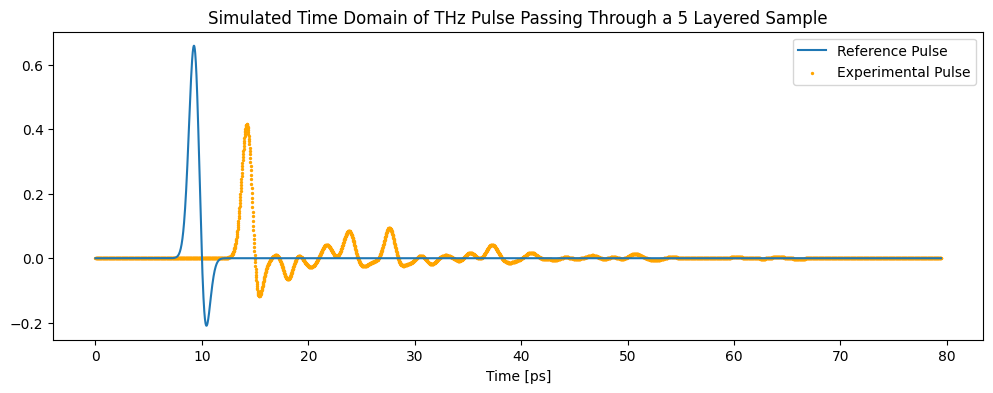

In [5]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n_values = [3.364, 2.522, 5.411, 4.213, 1.66]
k_values = [-0.000356, -0.003711, -0.005331, -0.008436, -0.009043]
d_values = [3.3e-05, 0.000179, 0.000102, 0.000206, 4.1e-05]

# Experimental material parameters (ground truth)
material_params_exp = [[(n_values[i] + 1j * k_values[i]), d_values[i]] for i in range(len(n_values))]


# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]


print("| Refractive Index | Absorption Coeff | Thickness [µm] |")
print("|------------------|------------------|----------------|")

for item in material_params_exp:
    n_real = np.real(item[0])
    n_imag = np.imag(item[0])
    thickness = item[1]
    print(f"| {n_real:16.3f} | {n_imag:16.6f} | {thickness:14.3e} |")

print('(Negative absorption coeff means loss in the material.)')

print(f'\nTotal Thickness: {sum(d_values) * 1e6} µm')

plt.figure(figsize=(12,4))
plt.title(f'Simulated Time Domain of THz Pulse Passing Through a {len(n_values)} Layered Sample')
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse')
#plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.scatter(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), s=2, color= 'orange',label='Experimental Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (3.114, 3.314)
Layer 1 - k ∈ (-0.01, 0.01)
Layer 2 - n ∈ (2.2119999999999997, 2.412)
Layer 2 - k ∈ (-0.01, 0.01)
Layer 3 - n ∈ (5.511, 5.710999999999999)
Layer 3 - k ∈ (-0.01, 0.01)
Layer 4 - n ∈ (4.4110000000000005, 4.611)
Layer 4 - k ∈ (-0.01, 0.01)
Layer 5 - n ∈ (1.66, 1.86)
Layer 5 - k ∈ (-0.01, 0.01)
[((3.114-0.01j), 3.3e-05), ((2.314912027399073-0.01j), 0.000179), ((5.511-0.01j), 0.000102), ((4.4110000000000005-0.01j), 0.000206), ((1.66-0.01j), 4.1e-05)]


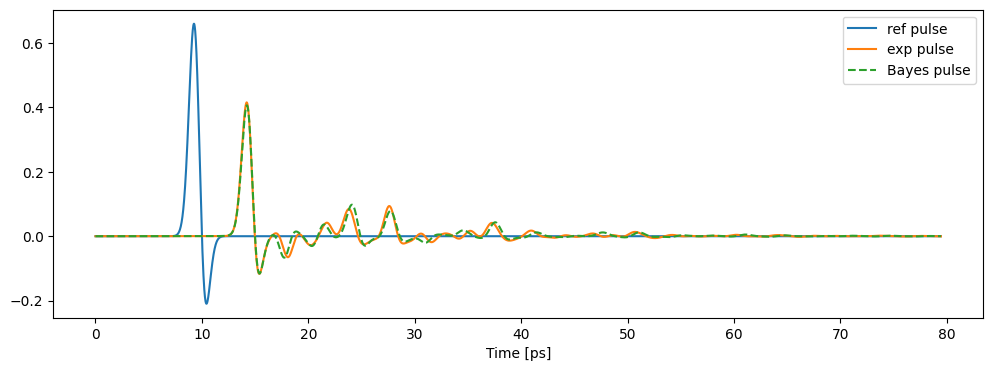

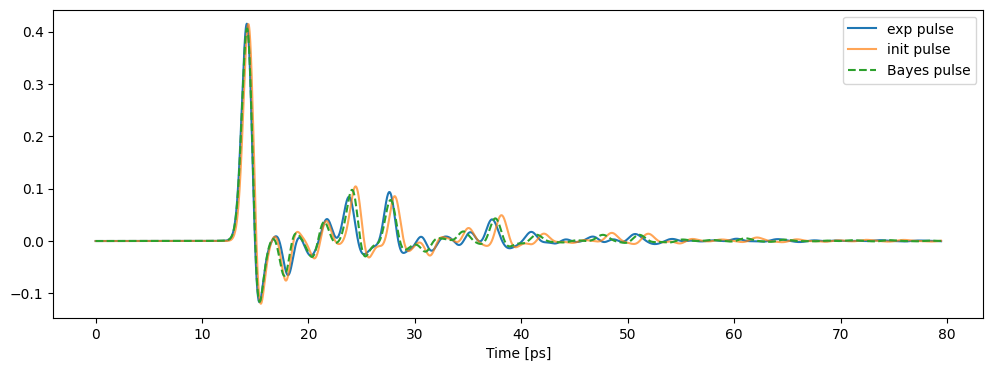

In [6]:
## Experimental params:

"""
| Refractive Index | Absorption Coeff | Thickness [µm] |
|------------------|------------------|----------------|
|            3.364 |        -0.000356 |      3.300e-05 |
|            2.522 |        -0.003711 |      1.790e-04 |
|            5.411 |        -0.005331 |      1.020e-04 |
|            4.213 |        -0.008436 |      2.060e-04 |
|            1.660 |        -0.009043 |      4.100e-05 |
"""

n_inits = [3.214, 2.312, 5.611, 4.511, 1.76]
k_inits = [0, 0, 0, 0, 0]
d_inits = [3.3e-05, 0.000179, 0.000102, 0.000206, 4.1e-05]


layers_init = [[(n_inits[i] + 1j * k_inits[i]), d_inits[i]] for i in range(len(n_inits))]

# Optimize with fixed thickness
optimization_mask = [
    (True, True, False),
    (True, True, False),
    (True, True, False),
    (True, True, False),
    (True, True, False)
]

initial_pulse = simulate_parallel(reference_pulse, layers_init, deltat)[1].detach().cpu().numpy()[:L]

Bayesian_optimizer = BayesianLayeredExtractor(reference_pulse, experimental_pulse, deltat, layers_init, optimize_mask=optimization_mask)
Bayesian_inits = Bayesian_optimizer.bayesian_optimization(n_calls=60)

Bayesian_pulse = simulate_parallel(reference_pulse, Bayesian_inits, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(Bayesian_inits)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, Bayesian_pulse, label='Bayes pulse', linestyle='--')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, initial_pulse, label='init pulse', alpha=0.7)
plt.plot(t_axis*1e12, Bayesian_pulse, label='Bayes pulse', linestyle='--')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

Fine-tuning 10 parameters for 500 iterations.
Iteration 49, Loss: 6.267562e-03, Layer 0: n=3.1373, k=-0.03417, D=33.00 µm | Layer 1: n=2.3721, k=0.00227, D=179.00 µm | Layer 2: n=5.4648, k=0.00225, D=102.00 µm | Layer 3: n=4.3656, k=-0.02169, D=206.00 µm | Layer 4: n=1.6150, k=-0.04682, D=41.00 µm
Iteration 99, Loss: 3.793520e-03, Layer 0: n=3.2065, k=-0.06627, D=33.00 µm | Layer 1: n=2.4355, k=0.00943, D=179.00 µm | Layer 2: n=5.4224, k=0.03848, D=102.00 µm | Layer 3: n=4.3235, k=-0.02115, D=206.00 µm | Layer 4: n=1.5731, k=-0.09588, D=41.00 µm
Iteration 149, Loss: 1.391392e-03, Layer 0: n=3.2780, k=-0.07881, D=33.00 µm | Layer 1: n=2.4984, k=0.02002, D=179.00 µm | Layer 2: n=5.3863, k=0.05163, D=102.00 µm | Layer 3: n=4.2825, k=-0.02018, D=206.00 µm | Layer 4: n=1.5347, k=-0.15018, D=41.00 µm
Iteration 199, Loss: 6.379159e-04, Layer 0: n=3.3184, k=-0.04376, D=33.00 µm | Layer 1: n=2.5250, k=0.01185, D=179.00 µm | Layer 2: n=5.3811, k=0.01096, D=102.00 µm | Layer 3: n=4.2561, k=-0.001

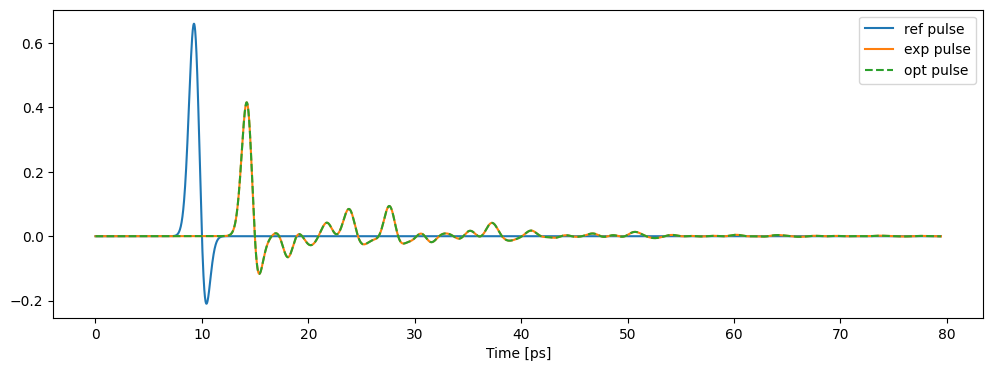

In [7]:
LE = LayeredExtractor(reference_pulse, experimental_pulse, deltat, Bayesian_inits, lr=0.001, optimize_mask=optimization_mask)
optim_params = LE.optimize(num_iterations=500, updates=50 , alpha=1)



_, optimal_pulse = simulate_parallel(reference_pulse, optim_params, deltat, noise_level=0)
optimal_pulse = optimal_pulse[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, optimal_pulse.detach().cpu().numpy(), label='opt pulse', linestyle='--')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

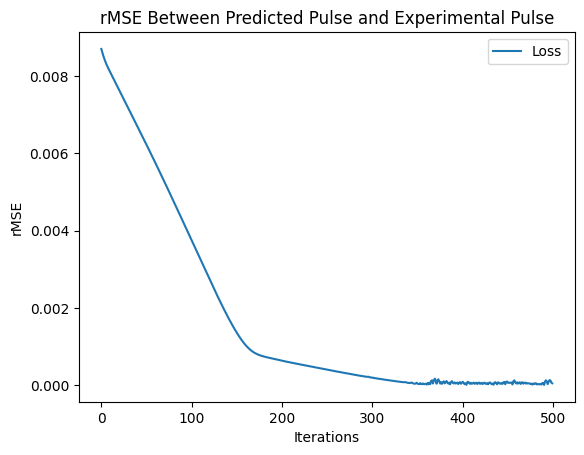

In [8]:
plt.plot(LE.loss_history, label='Loss')
plt.xlabel("Iterations")
plt.ylabel("rMSE")
plt.title("rMSE Between Predicted Pulse and Experimental Pulse")
plt.legend()
plt.show()

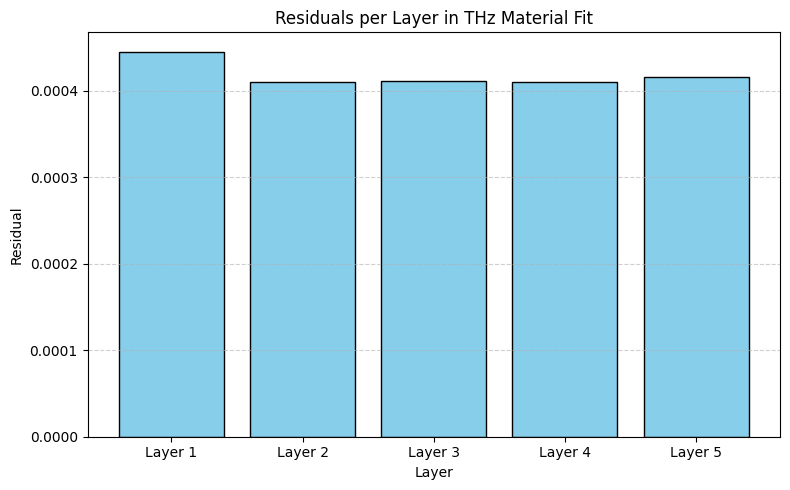

In [9]:
residuals = [material_params_exp[i][0] - optim_params[i][0] for i in range(len(material_params_exp))]
n_percentage_errors = [(np.real(residuals[i])/np.real(material_params_exp[i][0])) * 100 for i in range(len(residuals))]
k_percentage_errors = [(np.imag(residuals[i])/np.imag(material_params_exp[i][0])) * 100 for i in range(len(residuals))]

# Create bar plot
plt.figure(figsize=(8, 5))
layer_indices = [f"Layer {i+1}" for i in range(len(residuals))]

plt.bar(layer_indices, np.real(residuals), color='skyblue', edgecolor='black')
plt.title("Residuals per Layer in THz Material Fit")
plt.xlabel("Layer")
plt.ylabel("Residual")
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [10]:
k_percentage_errors, n_percentage_errors

([32.7429158552916,
  4.441987286035467,
  2.861823836738763,
  1.9010089631044544,
  2.086977352679976],
 [0.01324382605081714,
  0.016257159772315836,
  0.007609231836399125,
  0.009737936074679564,
  0.025079049259778458])

In [11]:
material_params_exp

[[(3.364-0.000356j), 3.3e-05],
 [(2.522-0.003711j), 0.000179],
 [(5.411-0.005331j), 0.000102],
 [(4.213-0.008436j), 0.000206],
 [(1.66-0.009043j), 4.1e-05]]